In [1]:
# Auto-reload internal modules
%load_ext autoreload
%autoreload 2

# External modules
import numpy as np

# Internal modules
from cosmotd.domain_walls import plot_domain_wall_simulation
from cosmotd.cosmic_strings import plot_cosmic_string_simulation
from cosmotd.charged_domain_walls import plot_charged_domain_wall_simulation
from cosmotd.pentavac import plot_pentavac_simulation
from cosmotd.single_axion import plot_single_axion_simulation
from cosmotd.companion_axion import plot_companion_axion_simulation
from cosmotd.plot import *
from cosmotd.parameters import *

In [2]:
# Size of simulation grid
N = 50
# Model parameters
beta = 1
eta_phi = 1
eta_sigma = np.sqrt(3) / 2
lam_phi = 2
lam_sigma = 2
charge_density = 0.1
# RNG seed
seed = 23213241
# Run time
run_time = None
# Plotter
plotter = MplNotebookPlotter

In [8]:
# Domain walls simulation
plot_domain_wall_simulation(200, DX, DT, ALPHA_2D, eta_phi, RADIATION_ERA, 5, MplMultiPlotter, run_time, seed)

100%|██████████| 1001/1001 [00:15<00:00, 66.45it/s]


In [ ]:
# Cosmic strings simulation
plot_cosmic_string_simulation(N, DX, DT, ALPHA_2D, eta_phi, RADIATION_ERA, 5, MplNotebookPlotter, run_time, seed)

In [ ]:
# Charged domain walls simulation
plot_charged_domain_wall_simulation(
    N,
    DX,
    DT,
    ALPHA_2D,
    beta,
    eta_phi,
    eta_sigma,
    lam_phi,
    lam_sigma,
    charge_density,
    RADIATION_ERA,
    MplNotebookPlotter,
    run_time,
    seed
)

In [ ]:
# Pentavac model simulation
epsilon = 0.1
plot_pentavac_simulation(N, N, DX, DT, ALPHA_2D, epsilon, RADIATION_ERA, plotter, run_time, seed)

<IPython.core.display.Javascript object>


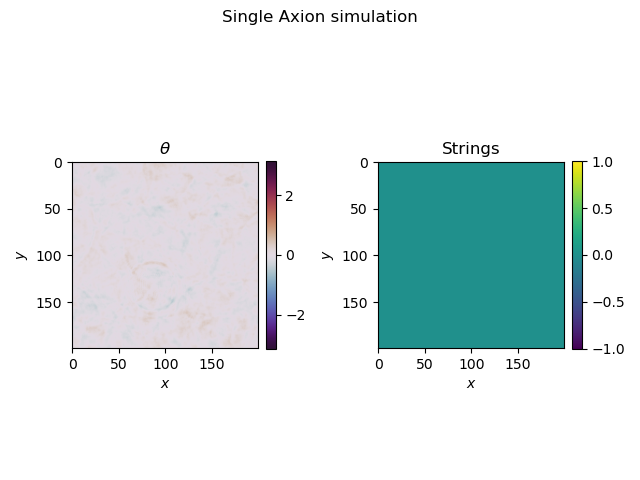

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [01:59<00:00,  8.38it/s]


In [5]:
# Single axion
lam = 5
color_anomaly = 1
K = 0.001 * lam
turn_on_time = 100
t0 = 100 * DT
growth = 1
plot_single_axion_simulation(200, DX, DT, ALPHA_2D, eta_phi, RADIATION_ERA, lam, color_anomaly, K, t0, growth, MplNotebookPlotter, run_time, seed)

In [8]:
# Companion axion
lam = 5
n = 3
n_prime = 1 / 2
m = 13 / 2
m_prime = 3 / 2
K = 0.5 * lam
kappa = 0.04
t0 = 100 * DT
n_growth = 1
m_growth = 1
plot_companion_axion_simulation(200, DX, DT, ALPHA_2D, eta_phi, RADIATION_ERA, lam, n, n_prime, m, m_prime, K, kappa, t0, n_growth, m_growth, MplMultiPlotter, run_time, seed)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [01:03<00:00, 15.88it/s]
